In [32]:
# Start loading libraries

#! pip install yfinance
#! pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


#! pip install pmdarima
import pmdarima as pm
from pmdarima import model_selection

import scipy
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
#from statsmodels.graphics.tsaplots import plot_acf
from numpy import asarray

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Input
from sklearn.preprocessing import MinMaxScaler

#from matplotlib.ticker import NullFormatter
#import yfinance as yf
#import warnings; warnings.simplefilter('ignore')
#%matplotlib inline

In [33]:
xls_file = pd.ExcelFile("Data_monthly_final.xlsx") # Read Excel
df1=xls_file.parse("Brent").set_index(['Timestamp']) # Read the Brent sheet, use first column as index

#df1["Timestamp"] = df1["Date"].astype('datetime64[ns]') # Convert column to date format
#df1.to_excel("values.xlsx")  #print to excel


In [34]:
xls_file2 = pd.ExcelFile("sbo_interpolated.xlsx") # Read Excel
df3=xls_file2.parse("Sheet1") # Read the first sheet (Portfolio holdings)

#df1["Timestamp"] = df1["Date"].astype('datetime64[ns]') # Convert column to date format
df3 = df3.set_index(['Timestamp']) # use first column as index

df3 = df3[[1,3,6,9,12]]*22.04623
df3.columns = ['BO_month1', 'BO_month3', 'BO_month6', 'BO_month9', 'BO_month12']
df3.describe()

,BO_month1,BO_month3,BO_month6,BO_month9,BO_month12
count,507.000000,507.000000,507.000000,507.000000,507.000000
mean,654.237894,656.268509,659.673470,660.585926,660.535735
std,290.165506,283.136041,277.017061,271.825749,268.254628
min,298.946879,308.828746,320.531072,328.488827,334.300417
25%,457.694598,464.293571,470.889177,473.896538,474.911654
50%,574.842921,570.029519,573.863367,569.551826,566.855246
75%,736.031554,739.163610,741.087588,750.322462,751.581595
max,1965.862329,1843.752519,1722.466240,1635.108979,1599.873219


In [35]:
df2=xls_file.parse("WTI").set_index(['Timestamp'])
df1 = pd.merge(df1, df2, how='left', on='Timestamp')

df2=xls_file.parse("Gasoil").set_index(['Timestamp'])
df1 = pd.merge(df1, df2, how='left', on='Timestamp')

df2=xls_file.parse("NatGas").set_index(['Timestamp'])
df1 = pd.merge(df1, df2, how='left', on='Timestamp')

df2=xls_file.parse("FCPO").set_index(['Timestamp'])
df1 = pd.merge(df1, df2, how='left', on='Timestamp')

#df2=xls_file.parse("SBO").set_index(['Timestamp'])
#df1 = pd.merge(df1, df2, how='left', on='Timestamp')

df1 = pd.merge(df1, df3, how='left', on='Timestamp')


df1.describe()

,LCOc1,LCOc3,LCOc6,LCOc9,LCOc12,CLc1,CLc3,CLc6,CLc9,CLc12,...,FCPOc1 USD,FCPOc3 USD,FCPOc6 USD,FCPOc9 USD,FCPOc12 USD,BO_month1,BO_month3,BO_month6,BO_month9,BO_month12
count,415.000000,413.000000,401.000000,378.000000,345.000000,415.000000,415.000000,415.000000,415.000000,414.000000,...,415.000000,392.000000,392.000000,337.000000,375.000000,415.000000,415.000000,415.000000,415.000000,415.000000
mean,50.039759,50.026392,50.836584,52.476455,55.481130,48.255422,48.350217,48.173157,47.894940,47.700097,...,571.691746,578.063262,564.944348,670.837715,379.219281,692.449042,694.408784,697.809230,698.894293,699.281084
std,33.148621,32.892269,32.633878,32.484768,31.960154,29.586085,29.629464,29.569256,29.457461,29.305416,...,268.370423,254.011060,246.249191,244.061359,398.023928,302.580423,295.320162,289.050790,283.572525,279.587174
min,10.460000,10.710000,11.340000,11.940000,12.280000,11.220000,12.140000,12.830000,13.130000,12.740000,...,187.656271,198.587937,0.000000,0.000000,0.000000,317.990324,325.230918,337.968706,348.991821,358.984705
25%,19.415000,19.280000,19.610000,19.682500,23.250000,20.655000,20.680000,20.525000,20.385000,20.077500,...,367.779414,371.918549,371.339232,507.706256,0.000000,481.930588,486.323556,488.934421,492.826654,496.283185
50%,43.300000,44.860000,48.140000,52.025000,56.260000,42.120000,43.210000,44.060000,44.640000,44.600000,...,521.121200,538.159826,523.181643,607.327971,506.811232,605.169014,604.924021,607.178227,598.182808,595.566656
75%,72.100000,72.470000,73.800000,74.850000,77.290000,69.845000,70.990000,70.170000,70.480000,70.035000,...,706.224931,709.699589,699.747068,808.629381,702.619061,775.973056,786.934340,800.934386,804.524758,810.394695
max,139.830000,141.280000,142.730000,143.220000,142.920000,140.000000,140.950000,141.560000,141.460000,140.870000,...,1775.738799,1631.340850,1469.533226,1441.785550,1426.958525,1965.862329,1843.752519,1722.466240,1635.108979,1599.873219


<Axes: xlabel='Timestamp'>

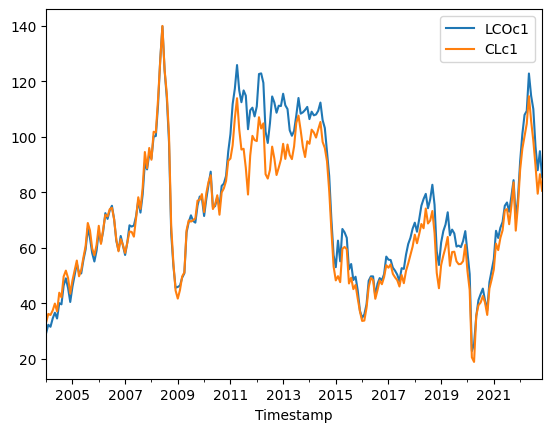

In [36]:
spot = df1[["LCOc1","CLc1","LGOc1","TRNLTTFD1 USD","FCPOc1 USD","BO_month1"]]
spot = spot.loc['2004-01-31':'2022-11-30']
#spot = np.log(spot).diff()
spot_train = spot.loc[:'2016-07-31']

spot[["LCOc1","CLc1"]].plot()

<Axes: xlabel='Timestamp'>

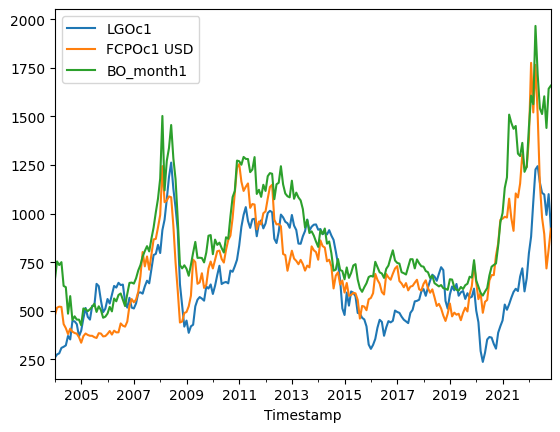

In [37]:
df3 = spot[spot["FCPOc1 USD"] != 0]
df3[["LGOc1","FCPOc1 USD","BO_month1"]].plot()

<Axes: xlabel='Timestamp'>

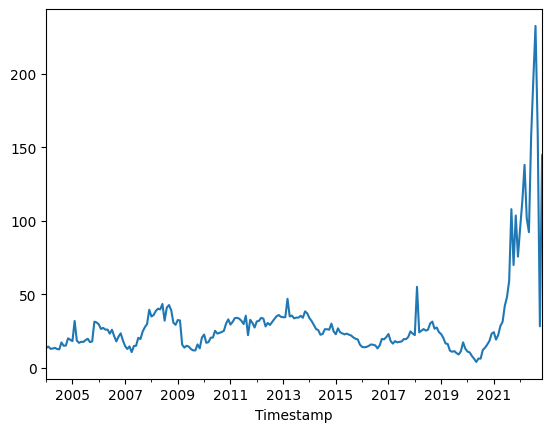

In [38]:
df4 = spot[spot["TRNLTTFD1 USD"] != 0]
df4["TRNLTTFD1 USD"].plot()

In [39]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 #n_vars = 1 if type(data) is list else data.shape[1]
 df_temp = pd.DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df_temp.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df_temp.shift(-i))
 # put it all together
 agg = pd.concat(cols, axis=1)
 # drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values

In [40]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [41]:
# fit an lstm model and make a one step prediction
def lstm_forecast(trainlocal, testX):
 # transform list into array
 trainlocalar = asarray(trainlocal)
 # split into input and output columns
 trainX, trainy = trainlocalar[:, :-1], trainlocalar[:, -1]

 # reshape input to be [samples, time steps, features]
 trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
 testX = np.reshape(testX, (1, testX.shape[0], 1))  ### batch size 1 because model is recalibrated after avery step
 #testX = np.reshape(testX, (testX.shape[0], trainX.shape[1], 1))     #### PURKKARATKAISU ###

 # create and fit the LSTM network
 model = Sequential()
 #model.add(InputLayer((time_lag,1)))
 model.add(InputLayer(batch_input_shape=(batch_size, trainX.shape[1], trainX.shape[2])))
 #model.add(LSTM(256))
 #model.add(LSTM(4))
 #model.add(LSTM(150, stateful = True, return_sequences=True))
 model.add(LSTM(12, stateful = True))
 model.add(Dense(1))
 model.compile(loss='mean_squared_error', optimizer='adam')
 for i in range(epochs):
  model.fit(trainX, trainy, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
  model.reset_states()
  #model.fit(trainX, trainy, epochs=1, batch_size=1, verbose=2)
  
 
 # make a one-step prediction
 
 yhat = model.predict(testX)
 return yhat[0]

In [42]:
# fix random seed for reproducibility
tf.random.set_seed(7)

time_lag = 12
batch_size = 1
epochs = 500

In [43]:
# Load the data and split it into separate pieces
data = np.array(np.log(spot[["LCOc1"]]).dropna())
train, test = model_selection.train_test_split(data, train_size=(spot_train.shape[0]))

# normalize the dataset
scaler1 = MinMaxScaler(feature_range=(0, 1)).fit(train.reshape(-1, 1))  ### using only train data in the scaling
data_scaled = scaler1.transform(data.reshape(-1, 1))

data_new = series_to_supervised(data_scaled, n_in=time_lag, n_out=1, dropnan=True)
#train, test = model_selection.train_test_split(data, train_size=(spot.shape[0]-1))

predictions = list()
# split dataset
train1, test1 = train_test_split(data_new, len(test))
# seed history with training dataset
history = [x for x in train1]
# step over each time-step in the test set
# split test row into input and output columns
testX, testy = test1[0, :-1], test1[0, -1]
# fit model on history and make a prediction
#yhat = lstm_forecast(history, testX)
# store forecast in list of predictions


trainlocal = history

# transform list into array
trainlocalar = asarray(trainlocal)
# split into input and output columns
trainX, trainy = trainlocalar[:, :-1], trainlocalar[:, -1]

# reshape input to be [samples, time steps, features]
#print(trainX)
#trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1] , 1))
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
#print(trainX.shape)
#print(trainX)
print(testX)
testX = np.reshape(testX, (1, testX.shape[0], 1))    
#print(testX.shape)

model = Sequential()
#model.add(InputLayer((time_lag,1)))
model.add(InputLayer(batch_input_shape=(batch_size, trainX.shape[1], trainX.shape[2])))
#model.add(LSTM(256))
#model.add(LSTM(4))
#model.add(LSTM(150, stateful = True, return_sequences=True))
model.add(LSTM(4, stateful = True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

loss = []
for i in range(epochs):
 history = model.fit(trainX, trainy, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
 loss.append(history.history['loss'])
 model.reset_states()
#model.fit(trainX, trainy, epochs=1, batch_size=1, verbose=2)

# make a one-step prediction
yhat = model.predict(testX)

predictions.append(yhat)
# add actual observation to history for the next loop and delete oldest one
#history.append(test1[i])
#history.pop(0)
# summarize progress
print('>expected=%.1f, predicted=%.1f' % (testy, yhat))

[0.39457344 0.32253628 0.3380469  0.27089325 0.15633837 0.1113047
 0.13350939 0.19486695 0.31936188 0.33971872 0.33959027 0.23936972]
139/139 - 2s - loss: 0.0641 - 2s/epoch - 13ms/step
139/139 - 1s - loss: 0.0300 - 512ms/epoch - 4ms/step
139/139 - 1s - loss: 0.0272 - 539ms/epoch - 4ms/step
139/139 - 1s - loss: 0.0249 - 541ms/epoch - 4ms/step
139/139 - 1s - loss: 0.0230 - 543ms/epoch - 4ms/step
139/139 - 1s - loss: 0.0214 - 557ms/epoch - 4ms/step
139/139 - 1s - loss: 0.0201 - 527ms/epoch - 4ms/step
139/139 - 1s - loss: 0.0190 - 527ms/epoch - 4ms/step
139/139 - 1s - loss: 0.0181 - 545ms/epoch - 4ms/step
139/139 - 1s - loss: 0.0172 - 551ms/epoch - 4ms/step
139/139 - 1s - loss: 0.0163 - 555ms/epoch - 4ms/step
139/139 - 1s - loss: 0.0156 - 536ms/epoch - 4ms/step
139/139 - 1s - loss: 0.0148 - 521ms/epoch - 4ms/step
139/139 - 1s - loss: 0.0139 - 541ms/epoch - 4ms/step
139/139 - 1s - loss: 0.0130 - 582ms/epoch - 4ms/step
139/139 - 1s - loss: 0.0121 - 533ms/epoch - 4ms/step
139/139 - 1s - loss:

C:\Users\tatuh\AppData\Local\Temp\ipykernel_7544\1037631562.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


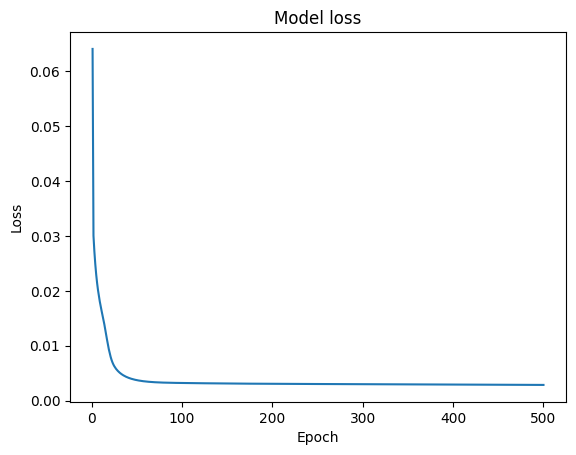

In [44]:
loss = pd.DataFrame(loss)
loss.index = np.arange(1, epochs+1)

#plt.plot(history.history['loss'])
plt.plot(loss)
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [45]:
### WTI

# Load the data and split it into separate pieces
data = np.array(np.log(spot[["CLc1"]]).dropna())
train, test = model_selection.train_test_split(data, train_size=(spot_train.shape[0]))

# normalize the dataset
scaler1 = MinMaxScaler(feature_range=(0, 1)).fit(train.reshape(-1, 1))  ### using only train data in the scaling
data_scaled = scaler1.transform(data.reshape(-1, 1))

data_new = series_to_supervised(data_scaled, n_in=time_lag, n_out=1, dropnan=True)
#train, test = model_selection.train_test_split(data, train_size=(spot.shape[0]-1))

predictions = list()
# split dataset
train1, test1 = train_test_split(data_new, len(test))
# seed history with training dataset
history = [x for x in train1]
# step over each time-step in the test set
# split test row into input and output columns
testX, testy = test1[0, :-1], test1[0, -1]
# fit model on history and make a prediction
#yhat = lstm_forecast(history, testX)
# store forecast in list of predictions


trainlocal = history

# transform list into array
trainlocalar = asarray(trainlocal)
# split into input and output columns
trainX, trainy = trainlocalar[:, :-1], trainlocalar[:, -1]

# reshape input to be [samples, time steps, features]
#print(trainX)
#trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1] , 1))
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
#print(trainX.shape)
#print(trainX)
print(testX)
testX = np.reshape(testX, (1, testX.shape[0], 1))    
#print(testX.shape)

model = Sequential()
#model.add(InputLayer((time_lag,1)))
model.add(InputLayer(batch_input_shape=(batch_size, trainX.shape[1], trainX.shape[2])))
#model.add(LSTM(256))
#model.add(LSTM(4))
#model.add(LSTM(150, stateful = True, return_sequences=True))
model.add(LSTM(4, stateful = True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

loss2 = []
for i in range(epochs):
 history = model.fit(trainX, trainy, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
 loss2.append(history.history['loss'])
 model.reset_states()
#model.fit(trainX, trainy, epochs=1, batch_size=1, verbose=2)

# make a one-step prediction
yhat = model.predict(testX)

predictions.append(yhat)
# add actual observation to history for the next loop and delete oldest one
#history.append(test1[i])
#history.pop(0)
# summarize progress
print('>expected=%.1f, predicted=%.1f' % (testy, yhat))

[0.27560703 0.21518041 0.2378494  0.16020813 0.07895206 0.01184491
 0.01451825 0.10284707 0.22781549 0.27419767 0.26324843 0.15937606]
139/139 - 2s - loss: 0.3756 - 2s/epoch - 11ms/step
139/139 - 0s - loss: 0.0463 - 481ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0408 - 439ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0377 - 499ms/epoch - 4ms/step
139/139 - 0s - loss: 0.0350 - 476ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0328 - 465ms/epoch - 3ms/step
139/139 - 1s - loss: 0.0309 - 515ms/epoch - 4ms/step
139/139 - 1s - loss: 0.0293 - 501ms/epoch - 4ms/step
139/139 - 0s - loss: 0.0279 - 488ms/epoch - 4ms/step
139/139 - 0s - loss: 0.0266 - 490ms/epoch - 4ms/step
139/139 - 0s - loss: 0.0255 - 496ms/epoch - 4ms/step
139/139 - 0s - loss: 0.0244 - 483ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0234 - 488ms/epoch - 4ms/step
139/139 - 1s - loss: 0.0225 - 502ms/epoch - 4ms/step
139/139 - 0s - loss: 0.0215 - 498ms/epoch - 4ms/step
139/139 - 0s - loss: 0.0206 - 479ms/epoch - 3ms/step
139/139 - 0s - loss

C:\Users\tatuh\AppData\Local\Temp\ipykernel_7544\2126573094.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


In [46]:
loss2

[[0.3755949139595032],
 [0.04634954780340195],
 [0.04083932191133499],
 [0.037668511271476746],
 [0.035034604370594025],
 [0.03282402828335762],
 [0.03094365820288658],
 [0.029319951310753822],
 [0.027895420789718628],
 [0.02662423439323902],
 [0.02547028474509716],
 [0.024405164644122124],
 [0.02340637519955635],
 [0.022455452010035515],
 [0.021536802873015404],
 [0.02063715271651745],
 [0.019745299592614174],
 [0.018852364271879196],
 [0.017952319234609604],
 [0.01704268343746662],
 [0.016125338152050972],
 [0.015207217074930668],
 [0.014300018548965454],
 [0.013418946415185928],
 [0.01258021593093872],
 [0.011798014864325523],
 [0.011082177050411701],
 [0.010437071323394775],
 [0.009862040169537067],
 [0.00935275387018919],
 [0.008902848698198795],
 [0.008505158126354218],
 [0.00815271120518446],
 [0.007839126512408257],
 [0.007558866403996944],
 [0.007307157386094332],
 [0.00708000035956502],
 [0.006874054670333862],
 [0.006686529144644737],
 [0.006515067536383867],
 [0.00635771173

In [47]:
### Gasoil loss

# Load the data and split it into separate pieces
data = np.array(np.log(spot[["LGOc1"]]).dropna())
train, test = model_selection.train_test_split(data, train_size=(spot_train.shape[0]))

# normalize the dataset
scaler1 = MinMaxScaler(feature_range=(0, 1)).fit(train.reshape(-1, 1))  ### using only train data in the scaling
data_scaled = scaler1.transform(data.reshape(-1, 1))

data_new = series_to_supervised(data_scaled, n_in=time_lag, n_out=1, dropnan=True)
#train, test = model_selection.train_test_split(data, train_size=(spot.shape[0]-1))

predictions = list()
# split dataset
train1, test1 = train_test_split(data_new, len(test))
# seed history with training dataset
history = [x for x in train1]
# step over each time-step in the test set
# split test row into input and output columns
testX, testy = test1[0, :-1], test1[0, -1]
# fit model on history and make a prediction
#yhat = lstm_forecast(history, testX)
# store forecast in list of predictions


trainlocal = history

# transform list into array
trainlocalar = asarray(trainlocal)
# split into input and output columns
trainX, trainy = trainlocalar[:, :-1], trainlocalar[:, -1]

# reshape input to be [samples, time steps, features]
#print(trainX)
#trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1] , 1))
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
#print(trainX.shape)
#print(trainX)
print(testX)
testX = np.reshape(testX, (1, testX.shape[0], 1))    
#print(testX.shape)

model = Sequential()
#model.add(InputLayer((time_lag,1)))
model.add(InputLayer(batch_input_shape=(batch_size, trainX.shape[1], trainX.shape[2])))
#model.add(LSTM(256))
#model.add(LSTM(4))
#model.add(LSTM(150, stateful = True, return_sequences=True))
model.add(LSTM(4, stateful = True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

loss3 = []
for i in range(epochs):
 history = model.fit(trainX, trainy, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
 loss3.append(history.history['loss'])
 model.reset_states()
#model.fit(trainX, trainy, epochs=1, batch_size=1, verbose=2)

# make a one-step prediction
yhat = model.predict(testX)

predictions.append(yhat)
# add actual observation to history for the next loop and delete oldest one
#history.append(test1[i])
#history.pop(0)
# summarize progress
print('>expected=%.1f, predicted=%.1f' % (testy, yhat))

[0.3977408  0.36885626 0.35685223 0.30528502 0.14676866 0.10222999
 0.14337737 0.2000198  0.29543862 0.35442375 0.33894107 0.22824125]
139/139 - 2s - loss: 0.0609 - 2s/epoch - 14ms/step
139/139 - 0s - loss: 0.0292 - 460ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0254 - 455ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0227 - 453ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0207 - 458ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0191 - 471ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0178 - 472ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0167 - 453ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0158 - 489ms/epoch - 4ms/step
139/139 - 0s - loss: 0.0149 - 491ms/epoch - 4ms/step
139/139 - 0s - loss: 0.0142 - 484ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0135 - 478ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0129 - 480ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0124 - 500ms/epoch - 4ms/step
139/139 - 0s - loss: 0.0119 - 497ms/epoch - 4ms/step
139/139 - 0s - loss: 0.0114 - 481ms/epoch - 3ms/step
139/139 - 1s - loss

C:\Users\tatuh\AppData\Local\Temp\ipykernel_7544\3185680788.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


In [48]:
### Natural Gas

# Load the data and split it into separate pieces
data = np.array(np.log(spot[["TRNLTTFD1 USD"]]).dropna())
train, test = model_selection.train_test_split(data, train_size=(spot_train.shape[0]))

# normalize the dataset
scaler1 = MinMaxScaler(feature_range=(0, 1)).fit(train.reshape(-1, 1))  ### using only train data in the scaling
data_scaled = scaler1.transform(data.reshape(-1, 1))

data_new = series_to_supervised(data_scaled, n_in=time_lag, n_out=1, dropnan=True)
#train, test = model_selection.train_test_split(data, train_size=(spot.shape[0]-1))

predictions = list()
# split dataset
train1, test1 = train_test_split(data_new, len(test))
# seed history with training dataset
history = [x for x in train1]
# step over each time-step in the test set
# split test row into input and output columns
testX, testy = test1[0, :-1], test1[0, -1]
# fit model on history and make a prediction
#yhat = lstm_forecast(history, testX)
# store forecast in list of predictions


trainlocal = history

# transform list into array
trainlocalar = asarray(trainlocal)
# split into input and output columns
trainX, trainy = trainlocalar[:, :-1], trainlocalar[:, -1]

# reshape input to be [samples, time steps, features]
#print(trainX)
#trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1] , 1))
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
#print(trainX.shape)
#print(trainX)
print(testX)
testX = np.reshape(testX, (1, testX.shape[0], 1))    
#print(testX.shape)

model = Sequential()
#model.add(InputLayer((time_lag,1)))
model.add(InputLayer(batch_input_shape=(batch_size, trainX.shape[1], trainX.shape[2])))
#model.add(LSTM(256))
#model.add(LSTM(4))
#model.add(LSTM(150, stateful = True, return_sequences=True))
model.add(LSTM(4, stateful = True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

loss4 = []
for i in range(epochs):
 history = model.fit(trainX, trainy, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
 loss4.append(history.history['loss'])
 model.reset_states()
#model.fit(trainX, trainy, epochs=1, batch_size=1, verbose=2)

# make a one-step prediction
yhat = model.predict(testX)

predictions.append(yhat)
# add actual observation to history for the next loop and delete oldest one
#history.append(test1[i])
#history.pop(0)
# summarize progress
print('>expected=%.1f, predicted=%.1f' % (testy, yhat))

[0.48880191 0.44776329 0.41631756 0.40260023 0.26413105 0.19392828
 0.18319172 0.19509487 0.22607183 0.27021557 0.26013938 0.24220264]
139/139 - 2s - loss: 0.1050 - 2s/epoch - 11ms/step
139/139 - 0s - loss: 0.0313 - 465ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0288 - 458ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0267 - 469ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0249 - 471ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0235 - 449ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0223 - 454ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0212 - 477ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0203 - 461ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0195 - 471ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0189 - 480ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0182 - 466ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0177 - 494ms/epoch - 4ms/step
139/139 - 0s - loss: 0.0172 - 472ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0167 - 470ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0163 - 479ms/epoch - 3ms/step
139/139 - 0s - loss

C:\Users\tatuh\AppData\Local\Temp\ipykernel_7544\2217375980.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


In [49]:
### Palm oil 

# Load the data and split it into separate pieces
data = np.array(np.log(spot[["FCPOc1 USD"]]).dropna())
train, test = model_selection.train_test_split(data, train_size=(spot_train.shape[0]))

# normalize the dataset
scaler1 = MinMaxScaler(feature_range=(0, 1)).fit(train.reshape(-1, 1))  ### using only train data in the scaling
data_scaled = scaler1.transform(data.reshape(-1, 1))

data_new = series_to_supervised(data_scaled, n_in=time_lag, n_out=1, dropnan=True)
#train, test = model_selection.train_test_split(data, train_size=(spot.shape[0]-1))

predictions = list()
# split dataset
train1, test1 = train_test_split(data_new, len(test))
# seed history with training dataset
history = [x for x in train1]
# step over each time-step in the test set
# split test row into input and output columns
testX, testy = test1[0, :-1], test1[0, -1]
# fit model on history and make a prediction
#yhat = lstm_forecast(history, testX)
# store forecast in list of predictions


trainlocal = history

# transform list into array
trainlocalar = asarray(trainlocal)
# split into input and output columns
trainX, trainy = trainlocalar[:, :-1], trainlocalar[:, -1]

# reshape input to be [samples, time steps, features]
#print(trainX)
#trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1] , 1))
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
#print(trainX.shape)
#print(trainX)
print(testX)
testX = np.reshape(testX, (1, testX.shape[0], 1))    
#print(testX.shape)

model = Sequential()
#model.add(InputLayer((time_lag,1)))
model.add(InputLayer(batch_input_shape=(batch_size, trainX.shape[1], trainX.shape[2])))
#model.add(LSTM(256))
#model.add(LSTM(4))
#model.add(LSTM(150, stateful = True, return_sequences=True))
model.add(LSTM(4, stateful = True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

loss5 = []
for i in range(epochs):
 history = model.fit(trainX, trainy, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
 loss5.append(history.history['loss'])
 model.reset_states()
#model.fit(trainX, trainy, epochs=1, batch_size=1, verbose=2)

# make a one-step prediction
yhat = model.predict(testX)

predictions.append(yhat)
# add actual observation to history for the next loop and delete oldest one
#history.append(test1[i])
#history.pop(0)
# summarize progress
print('>expected=%.1f, predicted=%.1f' % (testy, yhat))

[0.23899405 0.33904797 0.33416188 0.30659991 0.38686814 0.39637021
 0.42812909 0.54624599 0.51165388 0.48842671 0.43584194 0.41971346]
139/139 - 2s - loss: 0.0676 - 2s/epoch - 12ms/step
139/139 - 0s - loss: 0.0347 - 471ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0287 - 469ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0254 - 473ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0232 - 485ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0214 - 477ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0199 - 479ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0184 - 478ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0170 - 472ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0155 - 478ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0141 - 476ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0128 - 486ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0116 - 495ms/epoch - 4ms/step
139/139 - 0s - loss: 0.0106 - 498ms/epoch - 4ms/step
139/139 - 1s - loss: 0.0097 - 513ms/epoch - 4ms/step
139/139 - 0s - loss: 0.0090 - 487ms/epoch - 4ms/step
139/139 - 0s - loss

C:\Users\tatuh\AppData\Local\Temp\ipykernel_7544\3374550576.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


In [50]:
### Soybean oil

# Load the data and split it into separate pieces
data = np.array(np.log(spot[["CLc1"]]).dropna())
train, test = model_selection.train_test_split(data, train_size=(spot_train.shape[0]))

# normalize the dataset
scaler1 = MinMaxScaler(feature_range=(0, 1)).fit(train.reshape(-1, 1))  ### using only train data in the scaling
data_scaled = scaler1.transform(data.reshape(-1, 1))

data_new = series_to_supervised(data_scaled, n_in=time_lag, n_out=1, dropnan=True)
#train, test = model_selection.train_test_split(data, train_size=(spot.shape[0]-1))

predictions = list()
# split dataset
train1, test1 = train_test_split(data_new, len(test))
# seed history with training dataset
history = [x for x in train1]
# step over each time-step in the test set
# split test row into input and output columns
testX, testy = test1[0, :-1], test1[0, -1]
# fit model on history and make a prediction
#yhat = lstm_forecast(history, testX)
# store forecast in list of predictions


trainlocal = history

# transform list into array
trainlocalar = asarray(trainlocal)
# split into input and output columns
trainX, trainy = trainlocalar[:, :-1], trainlocalar[:, -1]

# reshape input to be [samples, time steps, features]
#print(trainX)
#trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1] , 1))
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
#print(trainX.shape)
#print(trainX)
print(testX)
testX = np.reshape(testX, (1, testX.shape[0], 1))    
#print(testX.shape)

model = Sequential()
#model.add(InputLayer((time_lag,1)))
model.add(InputLayer(batch_input_shape=(batch_size, trainX.shape[1], trainX.shape[2])))
#model.add(LSTM(256))
#model.add(LSTM(4))
#model.add(LSTM(150, stateful = True, return_sequences=True))
model.add(LSTM(4, stateful = True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

loss6 = []
for i in range(epochs):
 history = model.fit(trainX, trainy, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
 loss6.append(history.history['loss'])
 model.reset_states()
#model.fit(trainX, trainy, epochs=1, batch_size=1, verbose=2)

# make a one-step prediction
yhat = model.predict(testX)

predictions.append(yhat)
# add actual observation to history for the next loop and delete oldest one
#history.append(test1[i])
#history.pop(0)
# summarize progress
print('>expected=%.1f, predicted=%.1f' % (testy, yhat))

[0.27560703 0.21518041 0.2378494  0.16020813 0.07895206 0.01184491
 0.01451825 0.10284707 0.22781549 0.27419767 0.26324843 0.15937606]


139/139 - 2s - loss: 0.1041 - 2s/epoch - 12ms/step
139/139 - 0s - loss: 0.0360 - 457ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0325 - 459ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0299 - 470ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0279 - 457ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0263 - 455ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0249 - 467ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0238 - 453ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0229 - 475ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0220 - 476ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0212 - 473ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0205 - 476ms/epoch - 3ms/step
139/139 - 1s - loss: 0.0197 - 508ms/epoch - 4ms/step
139/139 - 0s - loss: 0.0190 - 486ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0183 - 475ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0176 - 482ms/epoch - 3ms/step
139/139 - 0s - loss: 0.0169 - 493ms/epoch - 4ms/step
139/139 - 0s - loss: 0.0161 - 492ms/epoch - 4ms/step
139/139 - 0s - loss: 0.0153 - 487ms/epoch - 4ms/

C:\Users\tatuh\AppData\Local\Temp\ipykernel_7544\54497185.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


In [51]:

loss2

[[0.3755949139595032],
 [0.04634954780340195],
 [0.04083932191133499],
 [0.037668511271476746],
 [0.035034604370594025],
 [0.03282402828335762],
 [0.03094365820288658],
 [0.029319951310753822],
 [0.027895420789718628],
 [0.02662423439323902],
 [0.02547028474509716],
 [0.024405164644122124],
 [0.02340637519955635],
 [0.022455452010035515],
 [0.021536802873015404],
 [0.02063715271651745],
 [0.019745299592614174],
 [0.018852364271879196],
 [0.017952319234609604],
 [0.01704268343746662],
 [0.016125338152050972],
 [0.015207217074930668],
 [0.014300018548965454],
 [0.013418946415185928],
 [0.01258021593093872],
 [0.011798014864325523],
 [0.011082177050411701],
 [0.010437071323394775],
 [0.009862040169537067],
 [0.00935275387018919],
 [0.008902848698198795],
 [0.008505158126354218],
 [0.00815271120518446],
 [0.007839126512408257],
 [0.007558866403996944],
 [0.007307157386094332],
 [0.00708000035956502],
 [0.006874054670333862],
 [0.006686529144644737],
 [0.006515067536383867],
 [0.00635771173

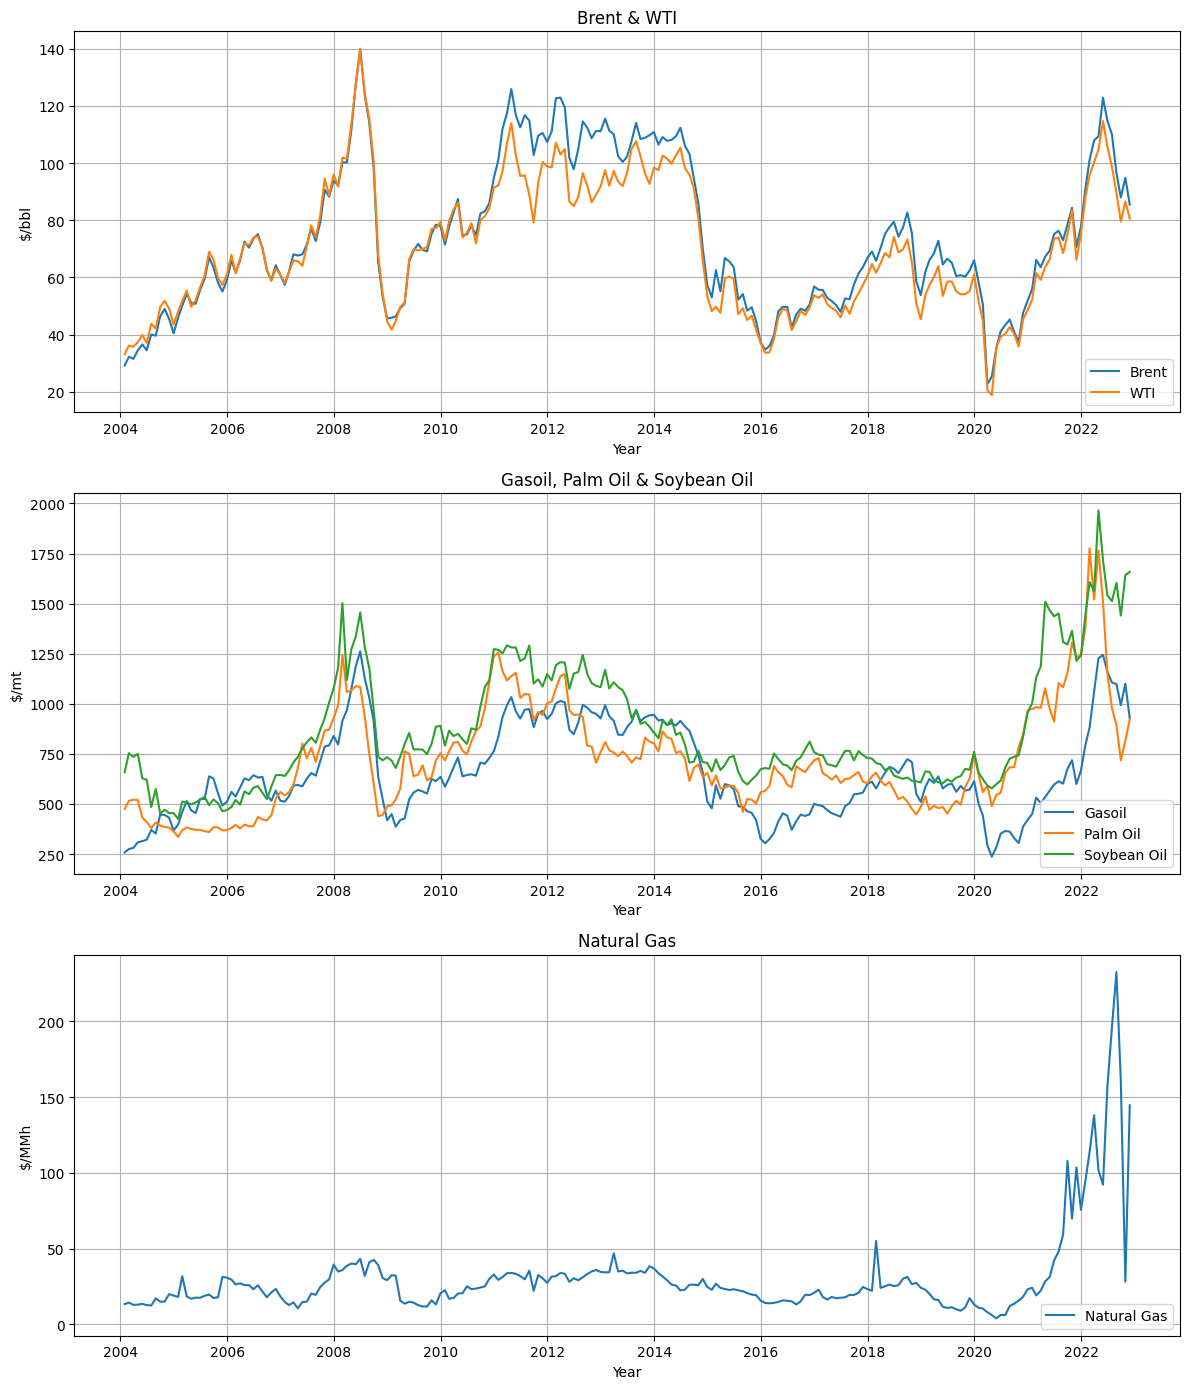

In [52]:
figure, axis = plt.subplots(3, 1, figsize=(12, 14))

axis[0].plot(spot[["LCOc1","CLc1"]], label=["Brent","WTI"])
axis[0].set_title("Brent & WTI")
axis[0].legend(loc="lower right")
axis[0].set_xlabel("Year")
axis[0].set_ylabel("$/bbl")
axis[0].grid()

axis[1].plot(df3[["LGOc1","FCPOc1 USD","BO_month1"]], label=['Gasoil', 'Palm Oil', 'Soybean Oil'])
axis[1].set_title("Gasoil, Palm Oil & Soybean Oil")
axis[1].legend(loc="lower right")
axis[1].set_xlabel("Year")
axis[1].set_ylabel("$/mt")
axis[1].grid()

axis[2].plot(df4[["TRNLTTFD1 USD"]], label='Natural Gas')
axis[2].set_title("Natural Gas")
axis[2].legend(loc="lower right")
axis[2].set_xlabel("Year")
axis[2].set_ylabel("$/MMh")
axis[2].grid()

figure.tight_layout()
plt.show()



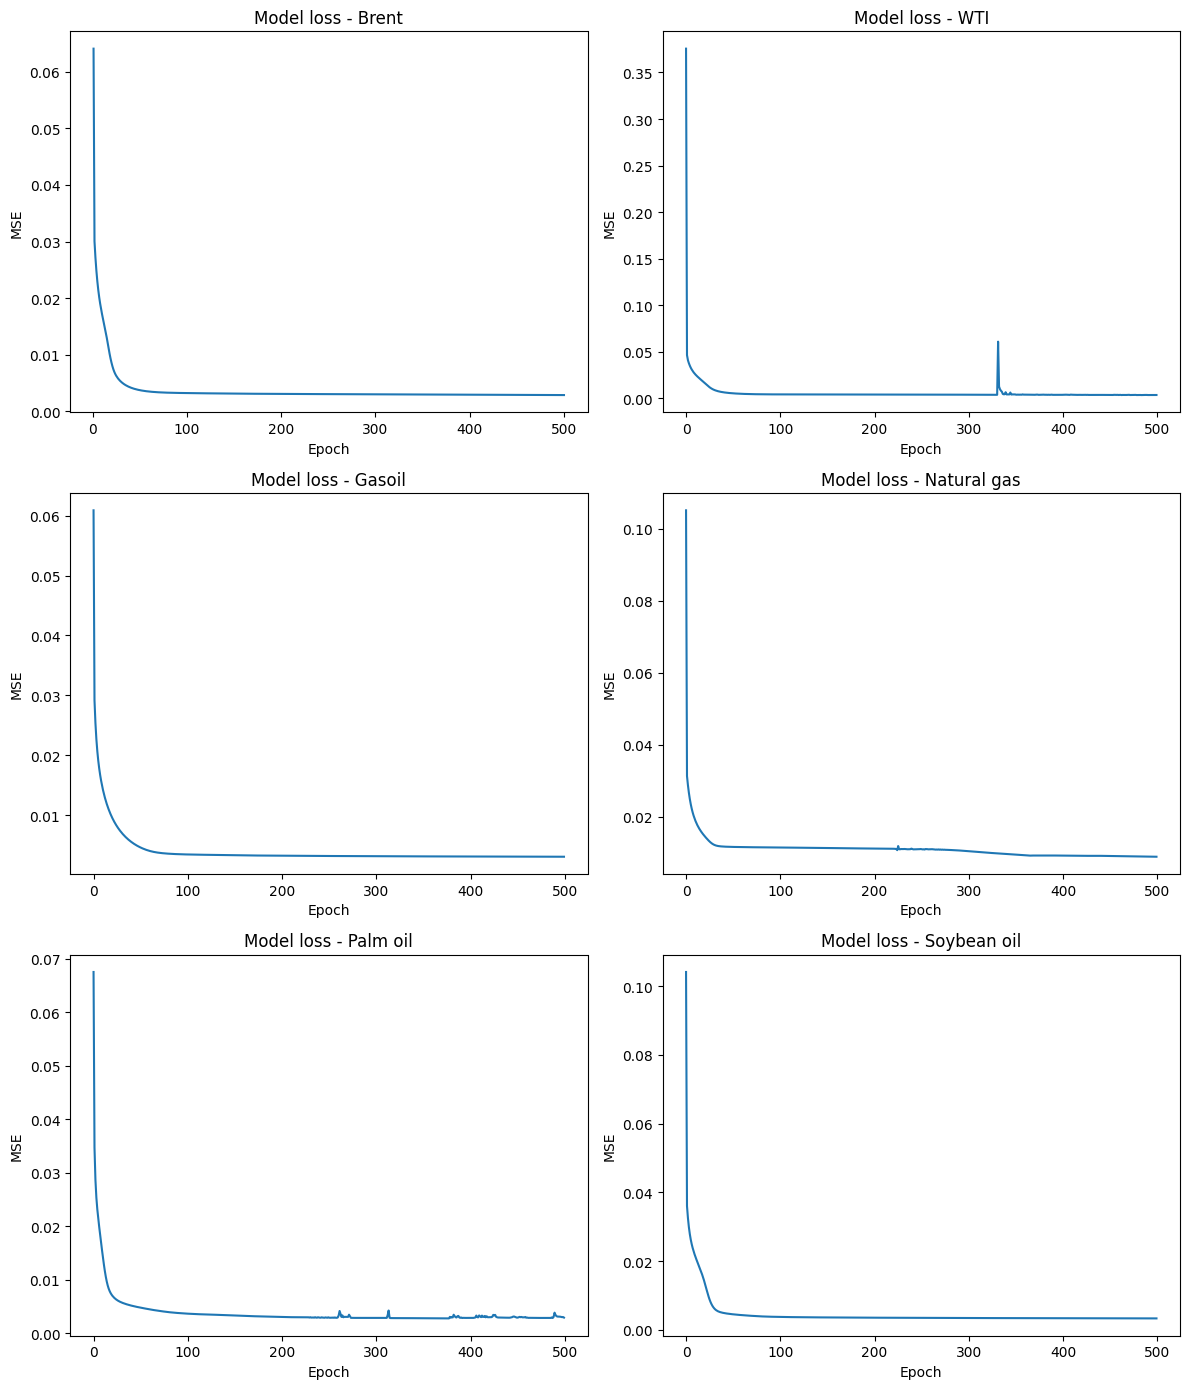

In [53]:
figure, axis = plt.subplots(3, 2, figsize=(12, 14))

#plot_acf(spot_log_train[["LCOc1"]], lags = 20, ax=axis[0,0])
axis[0,0].plot(loss)
axis[0,0].set_title("Model loss - Brent")
axis[0,0].set_xlabel("Epoch")
axis[0,0].set_ylabel("MSE")

axis[0,1].plot(loss2)
axis[0,1].set_title("Model loss - WTI")
axis[0,1].set_xlabel("Epoch")
axis[0,1].set_ylabel("MSE")

axis[1,0].plot(loss3)
axis[1,0].set_title("Model loss - Gasoil")
axis[1,0].set_xlabel("Epoch")
axis[1,0].set_ylabel("MSE")

axis[1,1].plot(loss4)
axis[1,1].set_title("Model loss - Natural gas")
axis[1,1].set_xlabel("Epoch")
axis[1,1].set_ylabel("MSE")

axis[2,0].plot(loss5)
axis[2,0].set_title("Model loss - Palm oil")
axis[2,0].set_xlabel("Epoch")
axis[2,0].set_ylabel("MSE")

axis[2,1].plot(loss6)
axis[2,1].set_title("Model loss - Soybean oil")
axis[2,1].set_xlabel("Epoch")
axis[2,1].set_ylabel("MSE")

figure.tight_layout()
plt.show()